This notebook uses saved models as they are in the paper.  
For an analysis ran from scratch please see `3-clustering_replication.ipynb`

In [1]:
import os
import sys
import pickle

import pandas as pd
import numpy as np
import ndjson

import matplotlib.pyplot as plt
import seaborn as sns

import umap
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import cdist_dtw
from tslearn.utils import to_time_series_dataset
from sklearn.cluster import AgglomerativeClustering

# plot settigns
plt.rcParams.update({"text.usetex": False,
                    "font.family": "Times New Roman",
                    "font.serif": "serif",
                    "mathtext.fontset": "cm",
                    "axes.unicode_minus": False,
                    "axes.labelsize": 9,
                    "xtick.labelsize": 9,
                    "ytick.labelsize": 9,
                    "legend.fontsize": 9,
                    "axes.linewidth": 1
                    })

In [2]:
# local scripts in src/
sys.path.append(os.path.join('..', 'src'))

from data_loader import extract_timeseries, ts_to_frame
from dtw_comparisons import calculate_pairwise_dtw
from dimensionality import fit_projection
from clusters import grid_search_clustering, plot_elbow, plot_dendrogram

<br>

# Processing signal

The following 3 cells contain code for creating the distance matrix between events. Unfortunately, it's written in a bad way, so the order of events (time series) changes with every run. Therefore, the distance matrix calculated here would be incompatible with models used in the paper (datapoints are in a different order).

Output of these 3 following cells will not be used for the clustering. 
Instead, models as-they-are in the paper will be imported.

In [3]:
# Load signal, curb ts length
dataset_path = os.path.join('output', 'event_flow_long_90.json')

with open(dataset_path) as fin:
    event_flow_90 = ndjson.load(fin)

ts30 = extract_timeseries(
    event_flow_90, window=28, remove_empty=True, undesired_newspapers=['all'])

df_ts30 = ts_to_frame(ts30)

In [4]:
# rescale
ts30_dict = {k: v for node in ts30 for k, v in node.items()}
event_keys = list(set(df_ts30['newspaper_event']))

signals = [ts30_dict[node] for node in event_keys]

ts_signals = to_time_series_dataset(signals)
ts_signals = TimeSeriesScalerMeanVariance().fit_transform(ts_signals)

In [5]:
# Calculate pairwise DTW distance between time series
dist_mat = cdist_dtw(ts_signals)

UMAP projection of distance matrix calculated in this notebook (same parameters as in the paper).  
Global structure is very similar to the projection used in the paper.

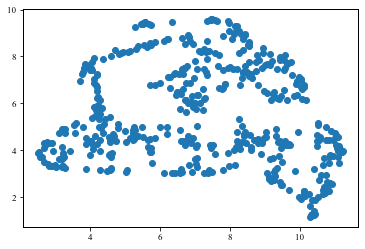

In [6]:
# Project to 2D with UMAP

X = umap.UMAP(random_state=42).fit_transform(dist_mat)

plt.scatter(X[:, 0], X[:, 1])

--- 
Models from the paper

In [7]:
# setup outdirs
analysis_dir = os.path.join('output', 'clusters', 'paper')

outdir = os.path.join(analysis_dir, 'grid_search')
outdir_dba = os.path.join(analysis_dir, 'dba')

for path in [outdir, outdir_dba]:
    if not os.path.exists(path):
        os.makedirs(path)
    else:
        print(f'path exists: {path}')

path exists: output/clusters/paper/grid_search
path exists: output/clusters/paper/dba


UMAP projection used in the paper.  
Clustering will be done on this.

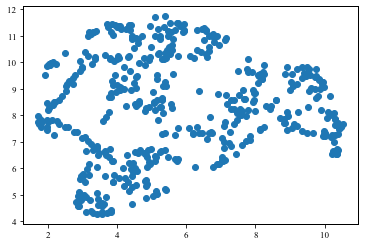

In [8]:
# UMAP projection used in the paper

with open(os.path.join(outdir, 'X.pcl'), 'rb') as fin:
    X_paper = pickle.load(fin)

plt.scatter(X_paper[:, 0], X_paper[:, 1]) 

<br>

# Grid search

In [9]:
# Parameters for grid search
# Split into two sets, because they are mutually exclusive
params_a = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8],
    'affinity': ['euclidean'],
    'compute_full_tree': [False],
    'linkage': ['ward', 'complete', 'average'],
    'distance_threshold': [None]
}

params_b = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8],
    'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
    'compute_full_tree': [False],
    'linkage': ['complete', 'average'],
    'distance_threshold': [None]
}

### Parameter space A

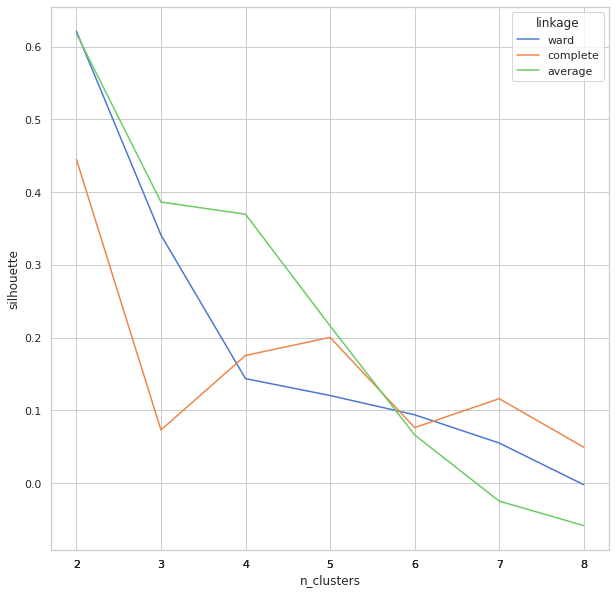

In [10]:
# Grid search through params_a
grid_a = grid_search_clustering(
    X=X_paper,
    parameters=params_a,
    algorithm=AgglomerativeClustering,
    use_silhouette=True,
)

grid_a_elbow, grid_a_df = plot_elbow(
    grid_a,
    metric='silhouette',
    prim_param='n_clusters',
    sec_param='linkage',
    get_df=True
)

grid_a_elbow.get_figure().savefig(os.path.join(outdir, 'grid_a_elbow.png'))

In [11]:
# models in params_a
(grid_a_df
    .sort_values('silhouette', ascending=False)
)

,silhouette,train_time,params,affinity,compute_full_tree,distance_threshold,linkage,n_clusters
0,0.620900,0.014257,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,ward,2
14,0.617887,0.008233,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,average,2
7,0.445008,0.079910,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,complete,2
15,0.386355,0.085922,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,average,3
16,0.369591,0.083944,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,average,4
1,0.340943,0.011833,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,ward,3
17,0.216150,0.011239,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,average,5
10,0.200345,0.083109,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,complete,5
9,0.175487,0.008801,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,complete,4
2,0.143621,0.079632,"{'affinity': 'euclidean', 'compute_full_tree':...",euclidean,False,None,ward,4


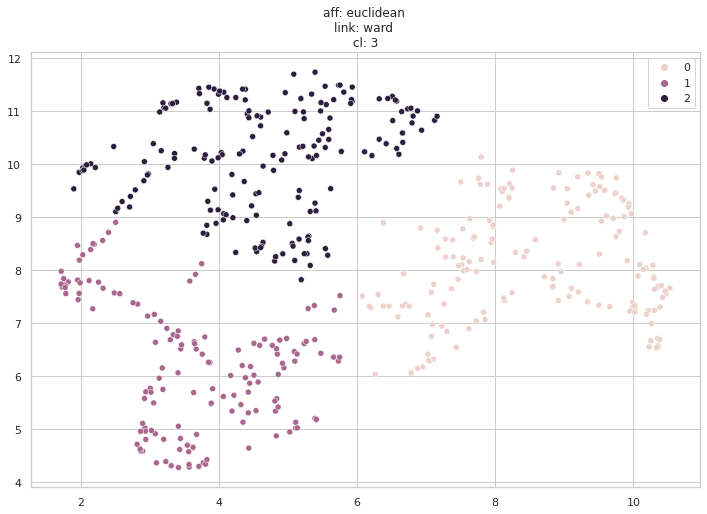

In [12]:
# best model from params_a
# best model from grid A
mdl_a = AgglomerativeClustering(
    affinity='euclidean',
    linkage='ward',
    n_clusters=3
)

mdl_a.fit(X_paper)

plt.figure(figsize=(12, 8))
fig_best_a = sns.scatterplot(
    x=X_paper[:, 0],
    y=X_paper[:, 1],
    hue=mdl_a.labels_)

plt.title(f'aff: {mdl_a.affinity} \nlink: {mdl_a.linkage} \ncl: {mdl_a.n_clusters}')

fig_best_a.get_figure().savefig(
    os.path.join(outdir, 'best_a.png')
    )

### Parameter space B

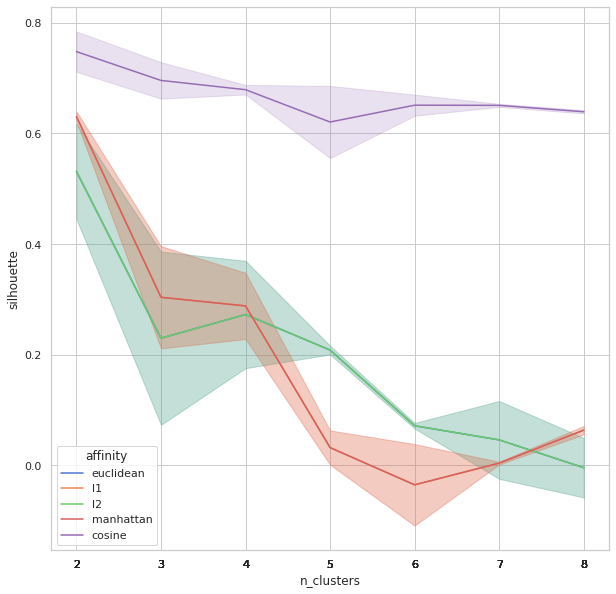

In [13]:
# Grid search through params_b
grid_b = grid_search_clustering(
    X=X_paper,
    parameters=params_b,
    algorithm=AgglomerativeClustering,
    use_silhouette=True
)

grid_b_elbow, grid_b_df = plot_elbow(
    grid_b,
    metric='silhouette',
    prim_param='n_clusters',
    sec_param='affinity',
    get_df=True
)

grid_b_elbow.get_figure().savefig(os.path.join(outdir, 'grid_b_elbow.png'))

In [14]:
(grid_b_df
    .query('affinity == "cosine"')
    .sort_values('silhouette', ascending=False)
)

,silhouette,train_time,params,affinity,compute_full_tree,distance_threshold,linkage,n_clusters
63,0.784596,0.082898,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,average,2
64,0.728859,0.009375,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,average,3
56,0.711487,0.008833,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,complete,2
65,0.687885,0.009307,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,average,4
66,0.685994,0.081976,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,average,5
58,0.670498,0.009096,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,complete,4
67,0.670256,0.083155,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,average,6
57,0.662969,0.008641,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,complete,3
68,0.653594,0.009241,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,average,7
61,0.648128,0.008811,"{'affinity': 'cosine', 'compute_full_tree': Fa...",cosine,False,None,complete,7


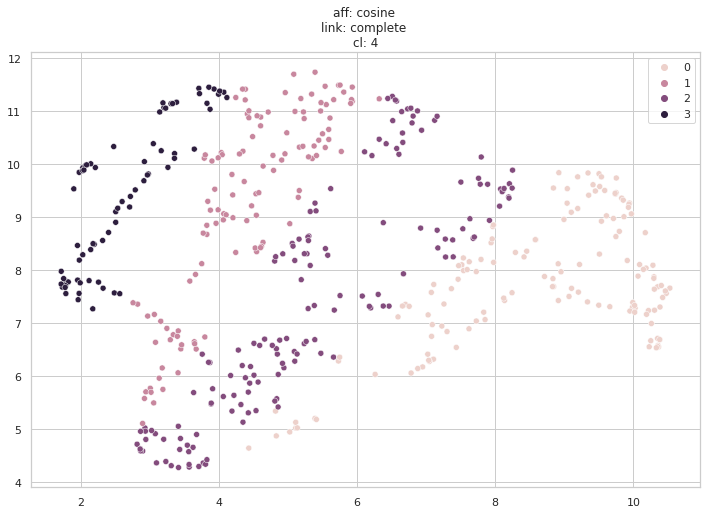

In [15]:
# Best model from params_b
mdl_b = AgglomerativeClustering(
    affinity='cosine',
    linkage='complete',
    n_clusters=4
)

mdl_b.fit(X_paper)

plt.figure(figsize=(12, 8))
fig_best_b = sns.scatterplot(
    x=X_paper[:, 0],
    y=X_paper[:, 1],
    hue=mdl_b.labels_)

plt.title(f'aff: {mdl_b.affinity} \nlink: {mdl_b.linkage} \ncl: {mdl_b.n_clusters}')

fig_best_b.get_figure().savefig(
    os.path.join(outdir, 'best_b.png')
    )

### Fit a full tree

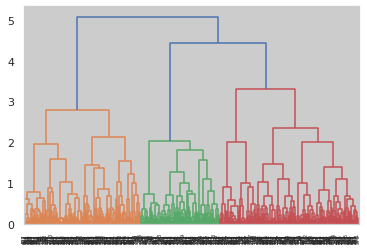

In [16]:
# See whole dendogram for validation
# Using the best model from both params_a and params_b
mdl_c = AgglomerativeClustering(
    affinity='euclidean',
    linkage='average',
    distance_threshold=0,
    n_clusters=None
)

mdl_c.fit(X_paper)

plot_dendrogram(mdl_c)

## Best model

Text(0.5, 1.0, 'aff: euclidean \nlink: average \ncl: 5')

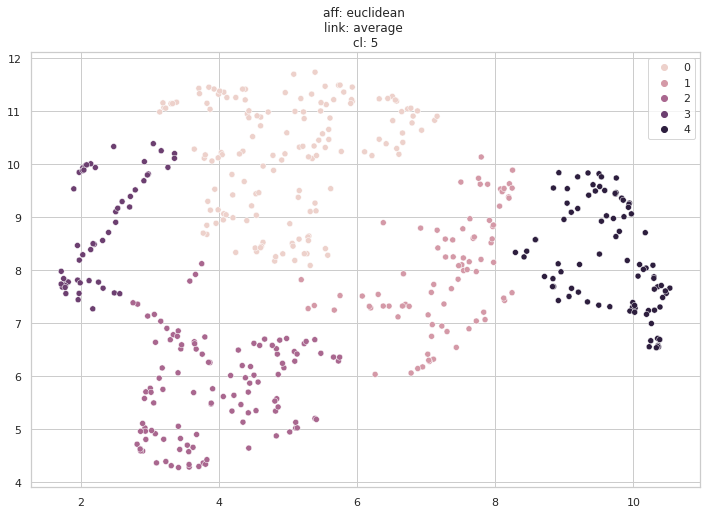

In [17]:
n_cl = 5

mdl_d = AgglomerativeClustering(
    affinity='euclidean',
    linkage='average',
    n_clusters=n_cl
)

mdl_d.fit(X_paper)

plt.figure(figsize=(12, 8))
fig_best_d = sns.scatterplot(
    x=X_paper[:, 0],
    y=X_paper[:, 1],
    hue=mdl_d.labels_)

plt.title(f'aff: {mdl_d.affinity} \nlink: {mdl_d.linkage} \ncl: {mdl_d.n_clusters}')

<br>

# Archetypical time series

In [18]:
with open(os.path.join(outdir, 'signal_n_dba.pcl'), 'rb') as fin:
    res_raw_paper = pickle.load(fin)

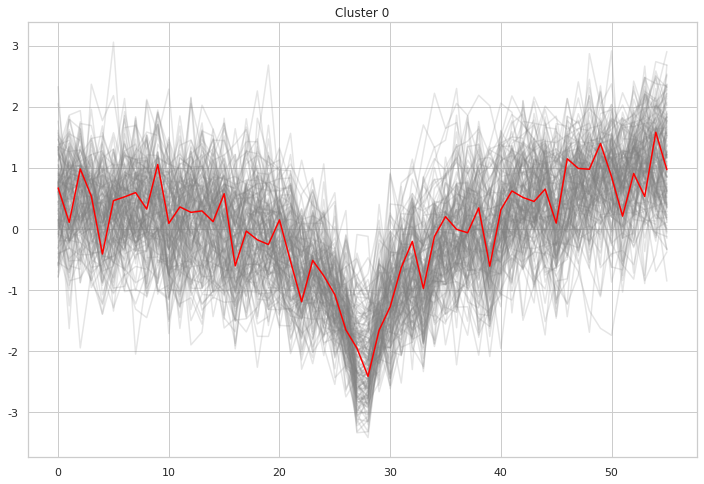

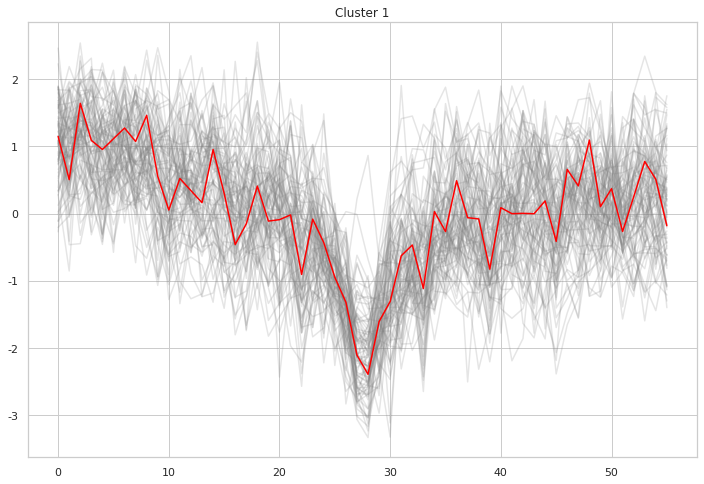

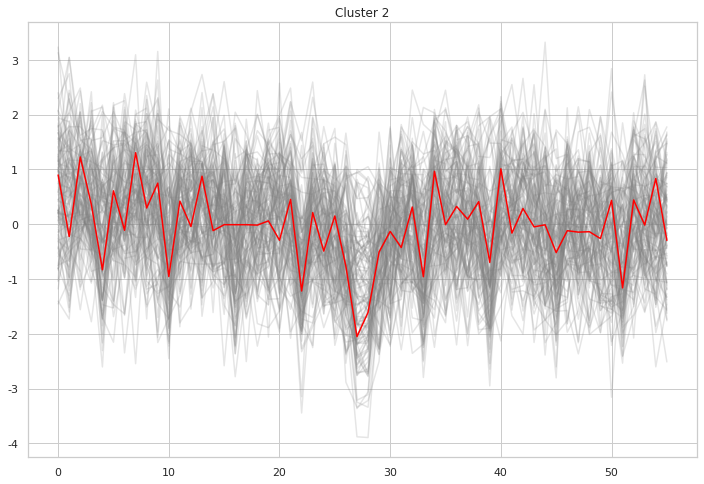

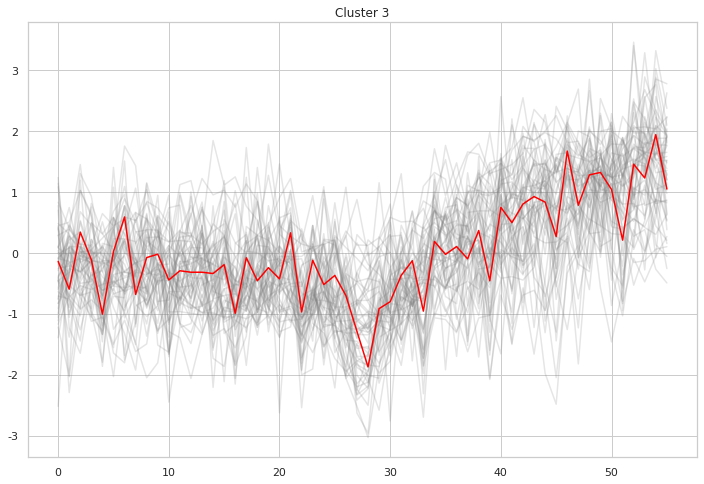

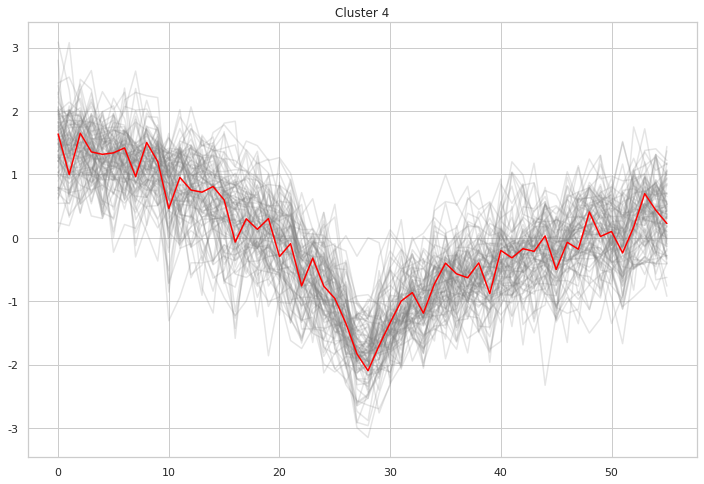

In [19]:
def plot_cluster(results, cluster_id:int, outpath):

    plt.figure(figsize=(12, 8))
    for series in results[cluster_id]['cluster_signals']:
        plt.plot(series, alpha=0.2, color='grey')
    plt.plot(results[cluster_id]['dba'], color='red')

    cluster_label = results[cluster_id]['cluster']
    plt.title(f'Cluster {cluster_label}')
    if outpath:
        plt.savefig(outpath)
    else:
        plt.show()


for i in range(0, n_cl, 1):
    fname = os.path.join(outdir_dba, str(i))
    if not os.path.exists(fname):
        plot_cluster(res_raw_paper, i, outpath=fname)
    else:
        print('warning: plot already exists!')

In [20]:
# save output
# models used in the paper are already saved and will not be overwritten

def dump_model(path, model):
    if not os.path.exists(path):
        with open(path, 'wb') as fout:
            pickle.dump(model, fout)
    else:
        print(f'{path} already exists')

dump_model(os.path.join(outdir, 'X.pcl'), X_paper)
dump_model(os.path.join(outdir, 'model_full.pcl'), mdl_c)
dump_model(os.path.join(outdir, 'model_best.pcl'), mdl_d)
dump_model(os.path.join(outdir, 'signal_n_dba.pcl'), res_raw_paper)

output/clusters/paper/grid_search/X.pcl already exists
output/clusters/paper/grid_search/model_full.pcl already exists
output/clusters/paper/grid_search/model_best.pcl already exists
output/clusters/paper/grid_search/signal_n_dba.pcl already exists


# Visualization

To get the dendrogram plot run:

```{shell}
cd event-flow/
python src/plot_clusters.py
```

The plot will be saved in `notebooks/output/clusters/{timestamp}_cluster_dendrogram.png`

The script uses saved models (as-is in the paper):
- umap projection (called X_paper in this notebook)
- mdl_c for the complete dendrogram
- mdl_d for cluster lables

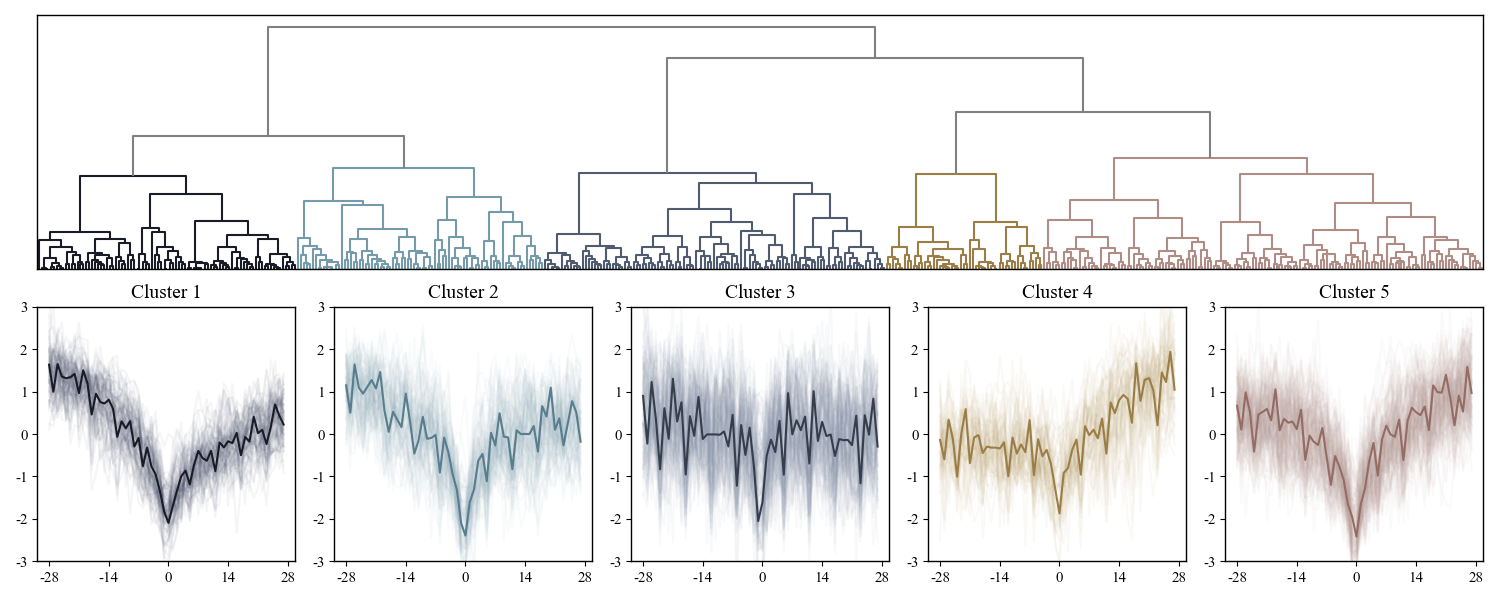

In [21]:
from IPython.display import Image

Image(os.path.join(analysis_dir, '20211014_cluster_dendrogram.png'))